# Código Base
link: https://goodboychan.github.io/python/tensorflow/mit/2021/02/14/music-generation.html

## Music Generation with RNNs

In [1]:
import tensorflow as tf 
import numpy as np
import os
import time
import regex as re
from IPython import display as ipythondisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
# import subprocess
# import urllib
# import functools
# import random

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0


# devices = tf.config.list_physical_devices()
# tf.config.experimental.set_visible_devices(devices[0]) # fixa para executar na CPU

# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# seed=1
# np.random.seed(seed)
# random.seed(seed)
# tf.random.set_seed(seed)



c:\Users\nmhahn\anaconda3\envs\tcc\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


## Dataset

In [2]:
def extract_song_snippet(text):
    pattern = '(^|\n\n)(.*?)\n\n'
    search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
    songs = [song[1] for song in search_results]
    # print("Found {} songs in text".format(len(songs)))
    return songs

cwd = os.getcwd()

songs = []

with open(os.path.join(cwd, 'data', 'irish', 'irish.abc'), 'r') as f:
    text = f.read()
    songs = extract_song_snippet(text)
    
# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)


Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [3]:
songs_joined = "\n\n".join(songs) 

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


## Process the dataset for the learning task

In [4]:
# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
#   we can evaluate `char2idx["d"]`.  
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

In [5]:
# print('{')
# for char,_ in zip(char2idx, range(20)):
#     print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
# print('  ...\n}')

In [6]:
'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

    NOTE: the output of the `vectorize_string` function 
    should be a np.array with `N` elements, where `N` is
    the number of characters in the input string
'''

def vectorize_string(string):
    vectorized_list = np.array([char2idx[s] for s in string])
    return vectorized_list

vectorized_songs = vectorize_string(songs_joined)

In [7]:
# print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# # check that vectorized_songs is a numpy array
# assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

## Create training examples and targets

In [8]:
def get_batch(vectorized_songs, seq_length, batch_size):
  n = vectorized_songs.shape[0] - 1

  idx = np.random.choice(n-seq_length, batch_size)

  input_batch = [vectorized_songs[i:i+seq_length] for i in idx]
  output_batch = [vectorized_songs[i+1: i+1+seq_length] for i in idx]

  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])

  return x_batch, y_batch


In [9]:
# x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

# for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
#     print("Step {:3d}".format(i))
#     print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
#     print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

## The Recurrent Neural Network (RNN) model

### Define the RNN model

In [10]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [11]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    tf.keras.layers.Dense(units=vocab_size)
  ])

  return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

### Test out the model

In [12]:
# model.summary()

In [13]:
# x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
# pred = model(x)
# print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
# print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

### Prediction from the untrained model

In [14]:
# sampled_indices = tf.random.categorical(pred[0], num_samples=1)
# sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
# # sampled_indices

# print("Input: \n", repr("".join(idx2char[x[0]])))
# print()
# print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

### Training the model: loss and training operations

In [15]:
'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

# '''TODO: compute the loss using the true next characters from the example batch 
#     and the predictions from the untrained model several cells above'''
# example_batch_loss = compute_loss(y, pred) 

# print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
# print("scalar_loss:      ", example_batch_loss.numpy().mean())

In [16]:
# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [17]:
class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

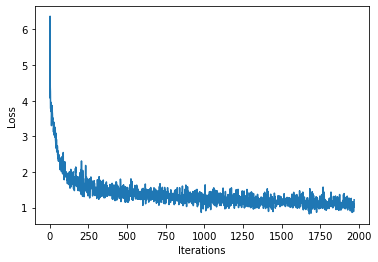

100%|██████████| 2000/2000 [02:19<00:00, 14.35it/s]


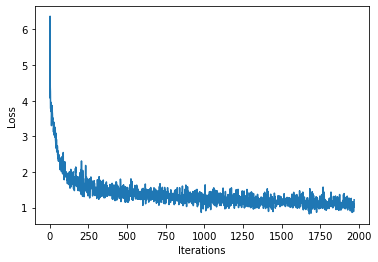

In [18]:
'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)

#@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)
  
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

###################
# Begin training! #
###################

history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

## Generate music using the RNN model

### Restore the latest checkpoint

In [19]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

# model.summary()

### The prediction procedure

In [20]:
def generate_text(model, start_string, choose='length', generation_length=None, n_songs=None):
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []

  model.reset_states()
  tqdm._instances.clear()

  if choose=='length':
    n = generation_length
    for i in tqdm(range(n)):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2char[predicted_id])
    
    text = (start_string + ''.join(text_generated))
  
  if choose=='n_songs':
    n = 0
    with tqdm(total=n_songs) as pbar:
      while n < n_songs:
        n0 = n
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])
        text = (start_string + ''.join(text_generated))
        aux = extract_song_snippet(text)
        n = len(aux)
        if n > n0: 
          pbar.update(1)
    
  return text

In [21]:
generated_text = generate_text(model, start_string="X:1\nT:", choose='length', generation_length=1000)
# generated_text = generate_text(model, start_string="X:1\nT:", choose='n_songs', n_songs=5)
print(generated_text)

100%|██████████| 1000/1000 [00:05<00:00, 167.11it/s]

X:1
T:y_=dBdef gfdf|!
fee2 fged|cABG A2GA|B2AG F2DF|!
(3ABc ABBA|GFGA BAFA|BFAF|BAGB A2:|!
AG|FAA2 edBA|B3G A3B|cFA E3:|!
EF|DFA AFA|dcd fed|ecA GFG|ged cAA|AGA A2d|!
eAA eAA|Bcd ege|dfg afd|d:dc-ocarolan-10
M:6/8
L:1/8
K:A Dorian
zE|EG AG/E/|DG AB|AG Ac|!
GB B2|c>d df|cA A2|!
ABA ABA|BgB A2G|EGA B2A|GED D2:|!

X:204
T:Preet Maguire
Z: id:dc-reel-29
M:C
L:1/8
K:G Major
AF|GBAG Bcdec|cAeg afge|dedc Bcde|f3d edef|gedB cAA2|]!
A2Bc BAGB|A2Bc cBAG|EDEF D2:|!

X:17
T:Fim Crippiagh
Z: id:dc-reel-23
M:C
L:1/8
K:G Major
d|gcAG fdfa|gfge fdBG|F2DF G2BG|AGEG GABG|AFGA BAA2|!
cAAG AGE2|GECB,D D2GA|B2AG FDD:|!

X:59
T:Caverind Tithera
Z: id:dc-reel-158
M:C
L:1/8
K:G Mixolydian
=F|A2cA AAFA|defg afeg|fded cdeg|f2ed Add2|efge dcBA|GED2 EAA2|eAA2 B=GGc|!
BGG2 ADcA|dfec dfed|^cdef g2fg|egge dBGB|cAeA cdec|A3B AGE:|!
Bc|dBGB AGFD|E3B A2bg|abag fefe|!
d2fd Aaaf|g2cB EGGA|BAGF G2DG|FDEE D2GA|!
d2ed edge|defd efge|dBB2 gBBd|efge dBGB|A2eA BAGB|!
G2AG BGG2|GdBG EGDD|EG=c:|!
BG|AFDF A Mixolydian
cA|BABc def

In [22]:
generated_songs = extract_song_snippet(generated_text)
print(generated_songs)
print(len(generated_songs))

['X:1\nT:y_=dBdef gfdf|!\nfee2 fged|cABG A2GA|B2AG F2DF|!\n(3ABc ABBA|GFGA BAFA|BFAF|BAGB A2:|!\nAG|FAA2 edBA|B3G A3B|cFA E3:|!\nEF|DFA AFA|dcd fed|ecA GFG|ged cAA|AGA A2d|!\neAA eAA|Bcd ege|dfg afd|d:dc-ocarolan-10\nM:6/8\nL:1/8\nK:A Dorian\nzE|EG AG/E/|DG AB|AG Ac|!\nGB B2|c>d df|cA A2|!\nABA ABA|BgB A2G|EGA B2A|GED D2:|!', 'X:204\nT:Preet Maguire\nZ: id:dc-reel-29\nM:C\nL:1/8\nK:G Major\nAF|GBAG Bcdec|cAeg afge|dedc Bcde|f3d edef|gedB cAA2|]!\nA2Bc BAGB|A2Bc cBAG|EDEF D2:|!', 'X:17\nT:Fim Crippiagh\nZ: id:dc-reel-23\nM:C\nL:1/8\nK:G Major\nd|gcAG fdfa|gfge fdBG|F2DF G2BG|AGEG GABG|AFGA BAA2|!\ncAAG AGE2|GECB,D D2GA|B2AG FDD:|!']
3


In [23]:
# from music21 import converter
# dir = 'geradas/teste'
# musica = 'gen2'
# s = converter.parse(dir+'/'+musica+'.abc')
# #s.show('midi')
# s.write('midi',fp=dir+'/'+musica+'.mid')

# def save_song_to_abc(song, filename="tmp"):
#     save_name = "{}.abc".format(filename)
#     with open(save_name, "w") as f:
#         f.write(song)
#     return filename

In [24]:
# caminhos
# - aparentemente, o código gera as músicas como deveria, mas sem reprodutibilidade...
# - inserir qualquer comando de fixar semente em "get_batch()" está dando problema
# - no entando, é possível fixar semente para peso inicial e para gerar caracteres/músicas dado o modelo com os pesos carregados (testar melhor)
# - talvez vale a pena criar alguns modelos deixando os pesos salvos, e gerar as músicas com base em uma seed determinada
# - talvez estabilizando o código, dê para realizar a computação na CPU para garantir reprodutibilidade
# próximos passos código
# - criar função para gerar midi partindo de ABC
# - limpar/manipular arquivos ABC para brincar com predição